In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import pandas as pd

import seaborn as sns

from scipy.signal import savgol_filter

from scipy.io import loadmat, savemat
from scipy.optimize import curve_fit
from scipy.integrate import cumtrapz

sns.set_theme(font_scale=1.5)

In [2]:
h = np.linspace(0, 999, 1000);
Earray = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)

def readAndAverage(filename):
    data = pd.read_csv("../spectral_data/" + filename, names=['E']);

    lineNo   = 1000;

    nThreads = int(len(data)/lineNo);
    
    ionResults = np.zeros([1, lineNo]);
    ionVar     = np.zeros([1, lineNo]);
    for i in range(0, nThreads):
        ionResults += data.E[lineNo*i:lineNo*(i+1)]
    
    for i in range(0, nThreads):
        ionVar += (data.E[lineNo*i:lineNo*(i+1)] - ionResults[0,:])**2;
    
    return ionResults.flatten(), np.sqrt(1/(nThreads-1) * ionVar.flatten());

def readAndAverage2D(filename):
    
    Earray = np.round(np.logspace(np.log10(0.250), np.log10(10000), 100), 2)

    data = pd.read_csv("../spectral_data/" + filename, names=Earray);
    
    lineNo   = 1000;
    
    nThreads = int(len(data)/lineNo);
    
    data.fillna(data.mean(), inplace=True)

    results    = np.zeros([lineNo, 100]);
    resultsVar = np.zeros([lineNo, 100]);
    for i in range(0, nThreads):
        results += data.values[lineNo*i:lineNo*(i+1), :]
        
    for i in range(0, nThreads):
        resultsVar += (data.values[lineNo*i:lineNo*(i+1), :] - results)**2

    return results, np.sqrt(1/(nThreads - 1) * resultsVar);

In [3]:
def integrate_diff_spectrum(x, y):
    I = np.zeros(np.shape(y))

    y[np.isnan(y)] = 0

    for i in range(0, len(y)):
        I[i] = np.trapz(y[i:len(y)], x=x[i:len(y)], axis=0)
    return I

In [4]:
mono_beams = {};
inv_energies = [100, 300, 1000, 3000, 3000, 3000]; # keV
data = {};
for_energies = [100, 300, 800];

for item in inv_energies:
    try:
        mono_beams[item] = pd.read_csv(
            "../../AEPEX/inversion_analysis/data/photon_data_inverse%.0fkeV_1e6.csv" % item, 
                                       names=['x','y','z','px','py','pz']);

        # Extract energy information from encoded momentum direction
        mono_beams[item].insert(6, "E", np.sqrt(mono_beams[item].px**2 + 
                                                mono_beams[item].py**2 + 
                                                mono_beams[item].pz**2));

        # Renormalize momentum directions to |p| = 1
        mono_beams[item].px /= mono_beams[item].E
        mono_beams[item].py /= mono_beams[item].E
        mono_beams[item].pz /= mono_beams[item].E
    except:
        print(item)
        pass
    
for item in for_energies:
    data[item] = pd.read_csv("../../AEPEX/inversion_analysis/data/photon_data_forward_%.0fkeV_1e6.csv" % item,
                                   names=['x','y','z','px','py','pz']);

    # Extract energy information from encoded momentum direction
    data[item].insert(6, "E", np.sqrt(data[item].px**2 + 
                                      data[item].py**2 + 
                                      data[item].pz**2));

    # Renormalize momentum directions to |p| = 1
    data[item].px /= data[item].E
    data[item].py /= data[item].E
    data[item].pz /= data[item].E

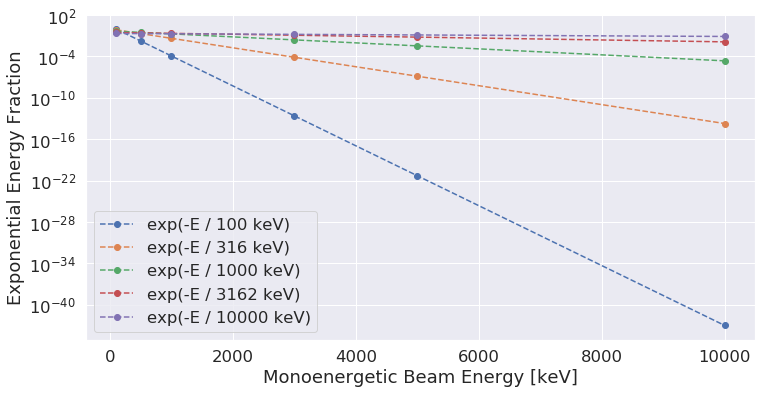

In [5]:
Emono = np.array([100, 500, 1000, 3000, 5000, 10000]);

plt.figure(figsize=(12,6)); plt.grid(True, which='both');

N = 5;
E0s = np.logspace(2, 4, N);

E0frac = np.zeros([N, len(Emono)]);
for ind, E0 in enumerate(E0s):
    E0frac[ind,:] = 1/E0 * np.exp(-Emono/E0)
    E0frac[ind,:] /= np.sum(E0frac[ind,:]);
    plt.plot(Emono, E0frac[ind,:], '.--', label='exp(-E / %.0f keV)' % E0, markersize=12);

plt.yscale('log');
#plt.xscale('log');
plt.xlabel('Monoenergetic Beam Energy [keV]');
plt.ylabel('Exponential Energy Fraction')
plt.legend();

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/matplotlib/contour.py:1544: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/matplotlib/contour.py:1543: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)


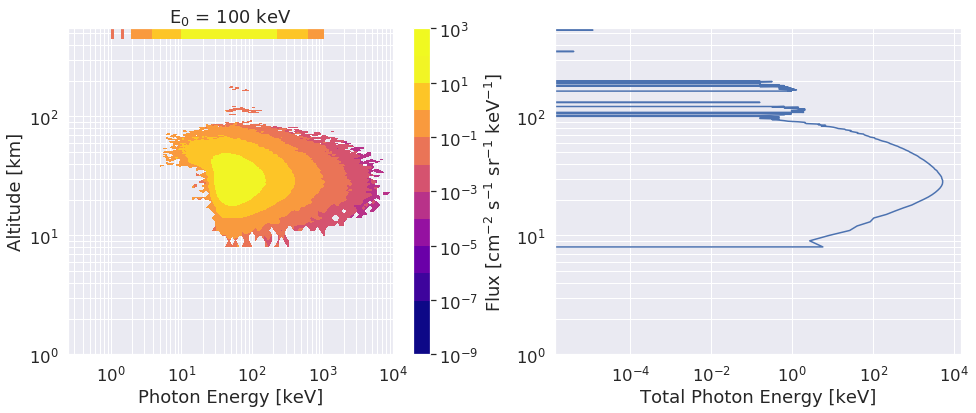

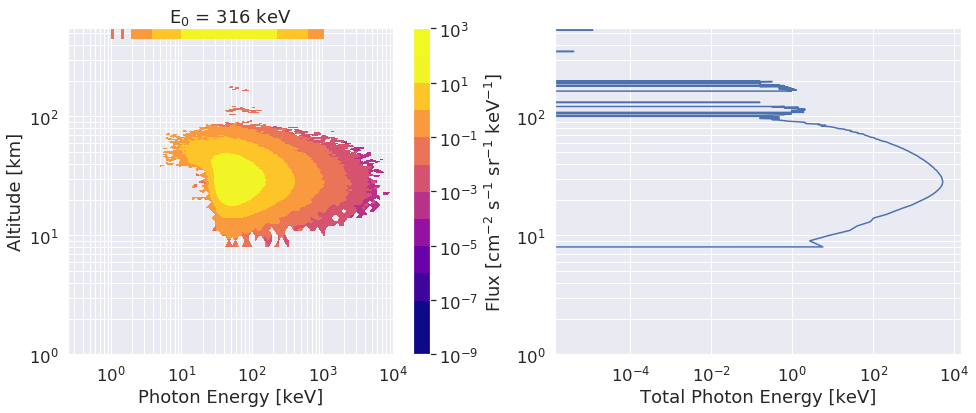

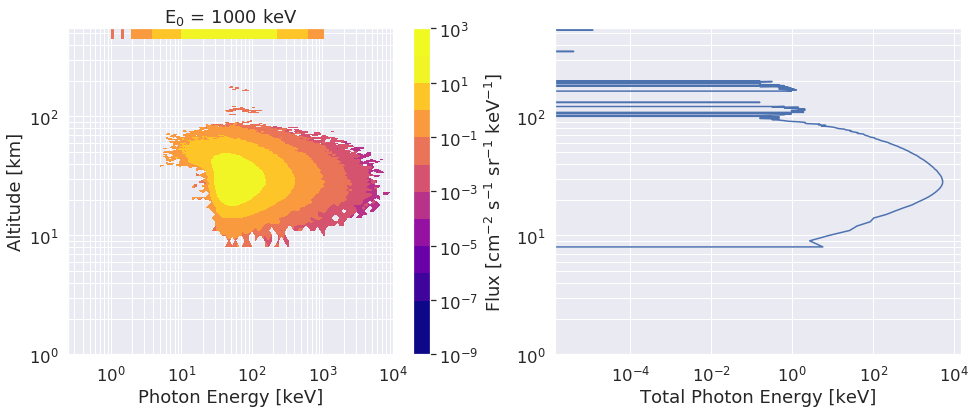

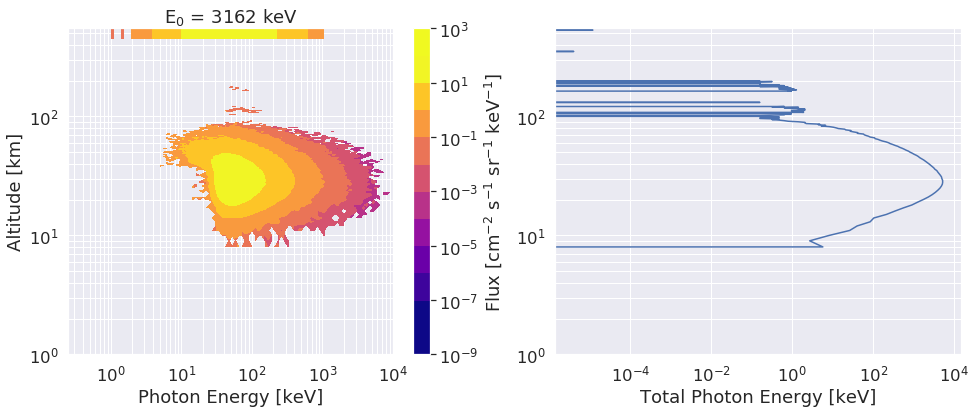

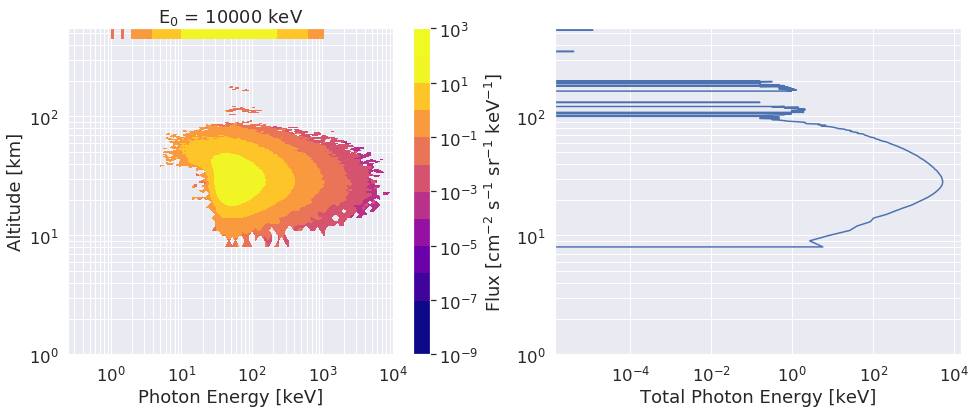

In [7]:
X,Y = np.meshgrid(Earray, h);

binWidth = np.diff(Earray);
binWidth = np.insert(binWidth, len(binWidth), binWidth[-1]);

hist, binEdges = np.histogram(data[800].E, bins=Earray)

Xp,Yp = np.meshgrid(binEdges[0:-1], h);


tmp_arr = np.zeros([len(binEdges[0:-1]), len(h)]);

tmp_arr[:,0:449] = np.nan;
tmp_arr[:,551:-1] = np.nan;
for i in range(450,551):
    tmp_arr[:,i] = hist.flatten()/1e1;

for ind, E0 in enumerate(E0s):
    
    plt.figure(figsize=(16,6)); plt.subplot(1,2,1); 
    plt.grid(True, which='both')
    
    photon_spectra = np.zeros([1000,100]);
    for i, post in enumerate(['100', '500', '1000', '3000', '5000', '10000']):
        ph_EResults, _     = readAndAverage2D("photon_ene_spectra" + post + "keV_iso_1e5.csv");

        #photon_spectra += E0frac[ind, i] * ph_EResults / binWidth;
        photon_spectra += ph_EResults / binWidth / 6;

    B1 = np.nanmin(  [np.nanmin(photon_spectra[photon_spectra > 0]),  np.nanmin(tmp_arr[tmp_arr > 0])])
    B2 = np.nanmax( [np.nanmax(photon_spectra) , np.nanmax(tmp_arr)] )
            
    plt.contourf(X,Y, photon_spectra, cmap='plasma', norm=matplotlib.colors.LogNorm(vmin=B1, vmax=B2));
    plt.colorbar(label='Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]');
    #plt.ylim(0,550);
    plt.xscale('log');
    plt.yscale('log');
    plt.ylim(1e0, 5.5e2)
    plt.xlabel('Photon Energy [keV]');
    plt.ylabel('Altitude [km]');
    plt.title('E$_0$ = %.0f keV' % E0)
    
    plt.contourf(Xp, Yp, tmp_arr.T, cmap='plasma', norm=matplotlib.colors.LogNorm(vmin=B1, vmax=B2));
    
    plt.subplot(1,2,2); plt.grid(True, which='both');
    I = integrate_diff_spectrum(Earray, tmp_arr);
    
                
    plt.plot(np.trapz(y=photon_spectra, x=Earray, axis=1), h);
    plt.xscale('log');
    plt.yscale('log');
    plt.ylim(1e0, 5.5e2);
    plt.xlabel('Total Photon Energy [keV]');

In [8]:
def powerFit(x, a, b, c):
    return b * (x+c)**-a

def weiFit(x, a, b):
    return b / x * np.exp(- x / a);

In [9]:
def plot_altitude_spectra(EResults, Evar):
    plt.subplot(1,2,2); plt.grid(True, which='both');

    startingAlt = 10;
    stepSize    = 5;

    for j in range(0, 4):

        h1 = startingAlt + j*stepSize;
        h2 = startingAlt + stepSize + j*stepSize;

        ave    = np.zeros([1, len(Earray)])
        aveVar = np.zeros([1, len(Earray)])
        for i in range(h1, h2):
            ave += EResults[i, :]
            aveVar += np.sqrt(Evar[i,:])

        plt.step(Earray, savgol_filter(ave[0,:], 1, 0), label='%.0f - %.0f km' % (h1,h2));

    plt.xscale('log');
    plt.yscale('log');
    plt.legend();
    plt.xlabel('Energy [keV]');
    #plt.ylabel('Relative Intensity');
    plt.title('Average Spectra with Altitude');

/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in greater
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/matplotlib/contour.py:1544: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/matplotlib/contour.py:1543: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/home/grant/anaconda3/envs/py3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


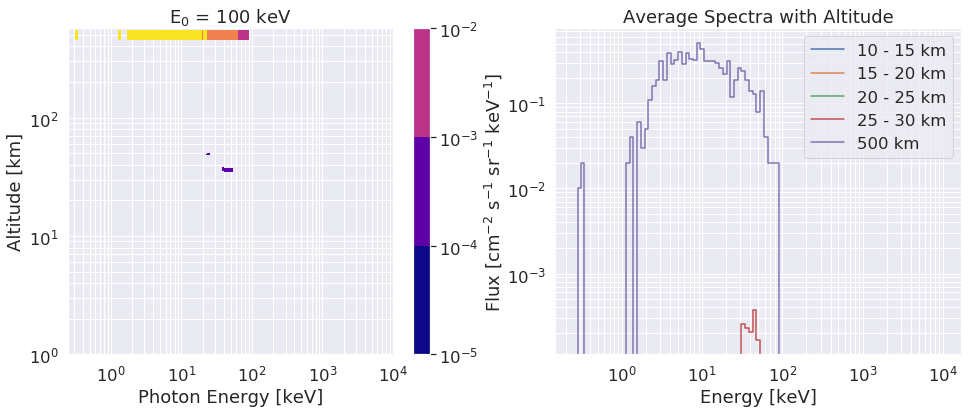

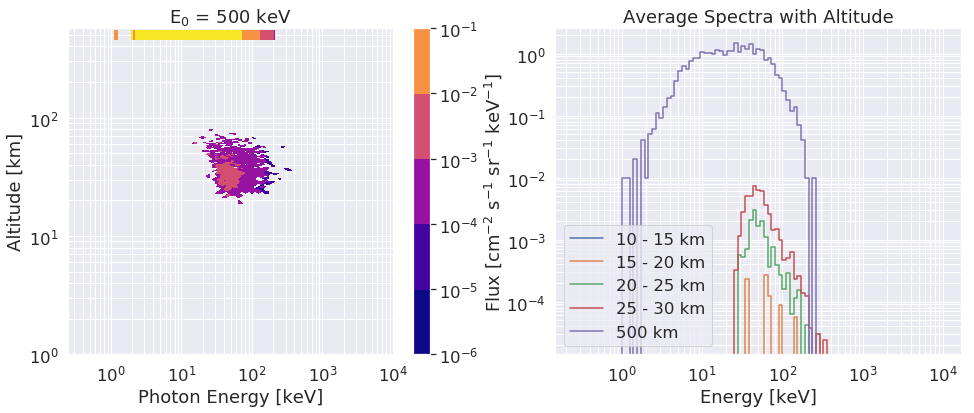

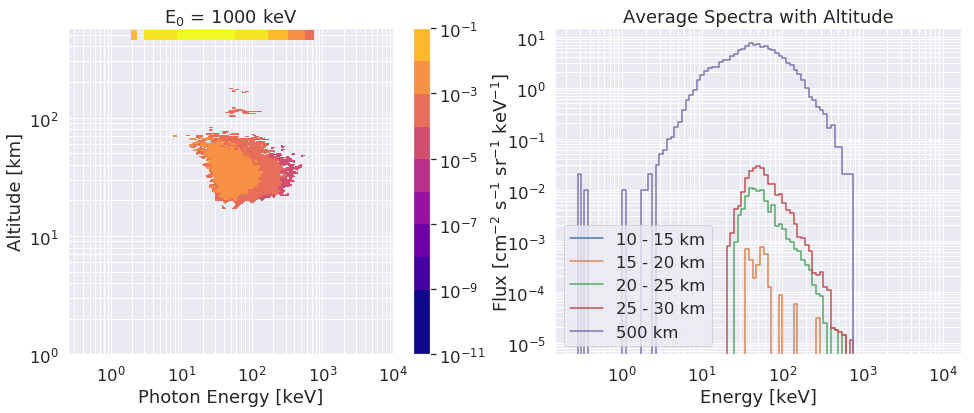

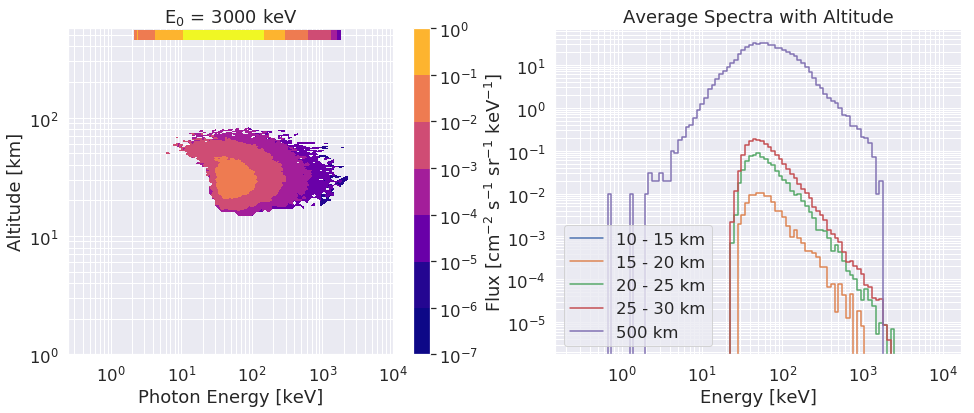

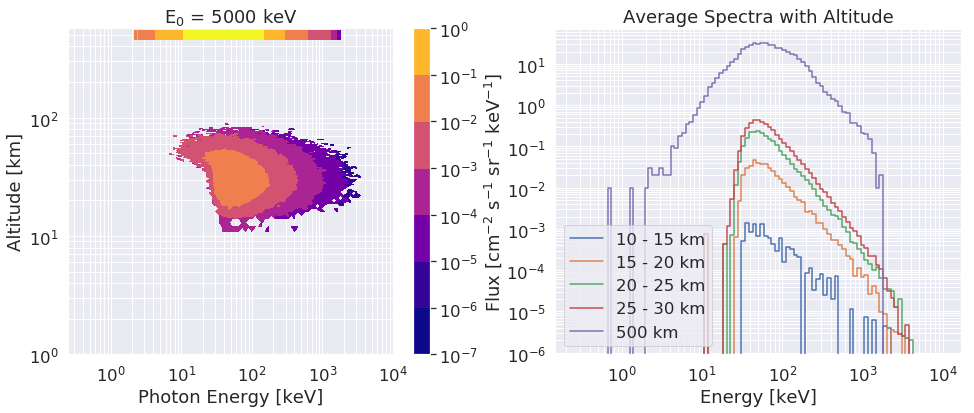

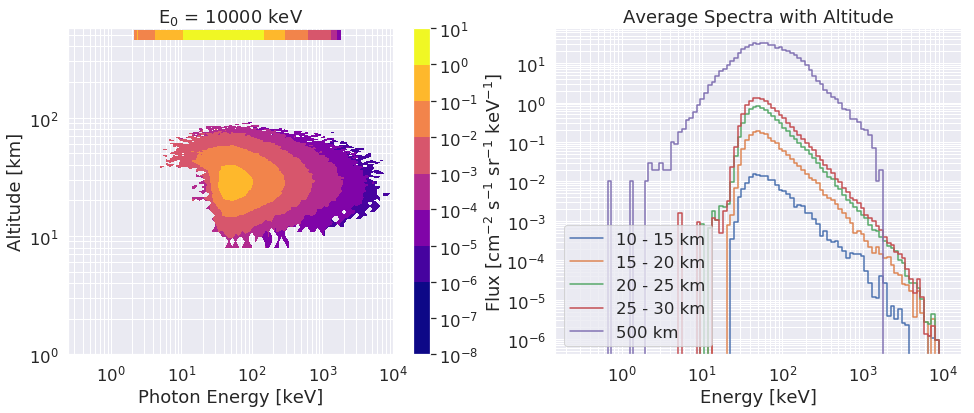

In [10]:
X, Y = np.meshgrid(Earray, h)

binWidth = np.diff(Earray)
binWidth = np.insert(binWidth, len(binWidth), binWidth[-1])

for i, post in enumerate(['100', '500', '1000', '3000', '5000', '10000']):

    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.grid(True, which='both')

    photon_spectra, _ = readAndAverage2D("photon_ene_spectra" + post +
                                         "keV_iso_1e5.csv")
    photon_spectra /= binWidth * 1e3

    hist, binEdges = np.histogram(mono_beams[inv_energies[i]].E, bins=Earray)

    Xp, Yp = np.meshgrid(binEdges[0:-1], h)

    tmp_arr = np.zeros([len(binEdges[0:-1]), len(h)])

    tmp_arr[:, 0:449] = np.nan
    tmp_arr[:, 551:-1] = np.nan
    for i in range(450, 551):
        tmp_arr[:, i] = hist.flatten() / binWidth[0:-1] / 1e2

    B1 = np.nanmin([
        np.nanmin(photon_spectra[photon_spectra > 0]),
        np.nanmin(tmp_arr[tmp_arr > 0])
    ])
    B2 = np.nanmax([np.nanmax(photon_spectra), np.nanmax(tmp_arr)])

    plt.contourf(X,
                 Y,
                 photon_spectra,
                 cmap='plasma',
                 norm=matplotlib.colors.LogNorm(vmin=B1, vmax=B2))
    plt.colorbar(label='Flux [cm$^{-2}$ s$^{-1}$ sr$^{-1}$ keV$^{-1}$]')
    # plt.ylim(0,550);
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e0, 5.7e2)
    plt.xlabel('Photon Energy [keV]')
    plt.ylabel('Altitude [km]')
    plt.title('E$_0$ = %s keV' % post)

    plt.contourf(Xp,
                 Yp,
                 tmp_arr.T,
                 cmap='plasma',
                 norm=matplotlib.colors.LogNorm(vmin=B1, vmax=B2))

    plot_altitude_spectra(photon_spectra, np.zeros(np.shape(ph_EResults)))
    plt.step(Earray[0:-1], hist / 1e2, label='500 km')

    max_ind = np.argmax(hist)

    end = len(hist) - np.where(hist > 0)[0][-1]
    
    opt_coef, _ = curve_fit(powerFit,
                            Earray[max_ind:-end - 1],
                            hist[max_ind:-end] / 1e2,
                            p0=[1e3, 3, Earray[max_ind]])

    '''
    plt.plot(Earray[0:-end],
             powerFit(Earray[0:-end], *opt_coef),
             label='Fit',
             linewidth=2.5)
     ''';

    plt.legend()